In [ ]:
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    Resize,
    Normalize,
)
import random

import torch
import torch.optim as optim
import torch.nn as nn

from torchvision.transforms import functional as TF
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from skin_cancer_cnn import SkinCancerCNN
from classification_model import ClassificationModelBuilding

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
# First check the dimensions of the images
# from PIL import Image
# from pathlib import Path

# widths, heights = [], []

# for img_path in Path(r"G:\My Drive\CS7643 Project\skin_cancer_train\malignant").glob(
#     "*.jpg"
# ):
#     with Image.open(img_path) as img:
#         w, h = img.size
#         widths.append(w)
#         heights.append(h)


# print(f"Width: min={min(widths)}, max={max(widths)}, medium={np.mean(widths)}")
# print(f"Height: min={min(heights)}, max={max(heights)}, medium={np.mean(heights)}")

In [3]:
class RandomRightRotation:
    def __init__(self, angles=[0, 90, 180, 270]):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return TF.rotate(img, angle)

In [ ]:
train_root_dir = "../data/skin_cancer_train"
val_root_dir = "../data/skin_cancer_val"

temp_transform = Compose([Resize(128), ToTensor()])
temp_dataset = ImageFolder(root=train_root_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=32)

In [5]:
import os
import fnmatch

class_counts = {}

for class_name in os.listdir(train_root_dir):
    class_path = os.path.join(train_root_dir, class_name)
    if os.path.isdir(class_path):
        num_jpgs = len(fnmatch.filter(os.listdir(class_path), "*.jpg"))
        class_counts[class_name] = num_jpgs

class_counts

{'benign': 9706, 'malignant': 294}

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

total_test_samples = sum(class_counts.values())
malignant_weight = class_counts["benign"] / class_counts["malignant"]
pos_weight = torch.tensor(malignant_weight, dtype=torch.float32).to(device)

In [7]:
# Compute mean and std of train set
n_pixels = 0
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)

for images, _ in temp_loader:
    n_pixels += images.numel() / 3  # Get total pixels per channel
    channel_sum += images.sum(dim=[0, 2, 3])  # Sum over batch, height, width
    channel_squared_sum += (images**2).sum(dim=[0, 2, 3])

mean = channel_sum / n_pixels
std = (channel_squared_sum / n_pixels - mean**2).sqrt()
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.6934, 0.5232, 0.4381])
Std: tensor([0.1298, 0.1255, 0.1216])


In [8]:
pos_data_transform = Compose(
    [
        Resize(128),
        ToTensor(),
        Normalize(mean, std),
        RandomHorizontalFlip(p=0.5),
        RandomVerticalFlip(p=0.5),
        RandomRightRotation(angles=[90, 180, 270]),
    ]
)
base_transform = Compose([Resize(128), ToTensor(), Normalize(mean, std)])


raw_train = ImageFolder(root=train_root_dir, transform=None)

In [9]:
class ConditionalAugDataset(Dataset):
    def __init__(self, base_dataset, pos_transform, base_transform):
        self.dataset = base_dataset
        self.pos_transform = pos_transform
        self.base_transform = base_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        if label == 1:
            img = self.pos_transform(img)
        else:
            img = self.base_transform(img)
        return img, label

In [10]:
train_dataset = ConditionalAugDataset(raw_train, pos_data_transform, base_transform)
val_dataset = ImageFolder(root=val_root_dir, transform=base_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [12]:
torch.manual_seed(13)
model = SkinCancerCNN(p=0.5)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

built_model = ClassificationModelBuilding(
    model, loss_fn, optimizer, train_loader, val_loader
)
built_model.fit(epochs=10)

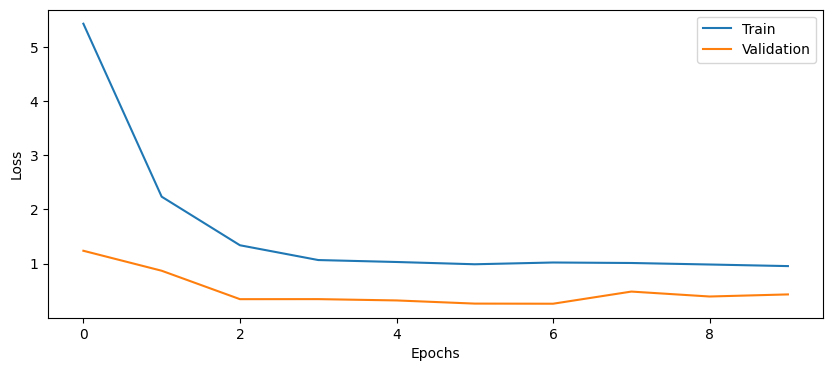

In [13]:
fig = built_model.plot_losses()

In [23]:
val_preds = []
true_labels = []

for x_batch, y_batch in val_loader:
    preds = built_model.predict(x_batch)
    true_labels.extend(y_batch)
    val_preds.extend(preds)

val_preds = np.array(val_preds)

thresholds = [0.2, 0.3, 0.4,0.5,0.6,0.7,0.8]

results = []

for threshold in thresholds:
    pred = (val_preds >= threshold).astype(int)

    acc = accuracy_score(true_labels, pred)
    precision = precision_score(true_labels, pred)
    recall = recall_score(true_labels, pred)
    f1 = f1_score(true_labels, pred)

    results.append({
        'threshold': threshold,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "F1 score": f1
    })

df_result = pd.DataFrame(results)
df_result.sort_values(by='recall', ascending = False)

,threshold,accuracy,precision,recall,F1 score
0,0.2,0.468,0.141234,0.966667,0.246459
1,0.3,0.658,0.200000,0.933333,0.329412
2,0.4,0.778,0.278523,0.922222,0.427835
3,0.5,0.855,0.370892,0.877778,0.521452
4,0.6,0.888,0.435294,0.822222,0.569231
5,0.7,0.908,0.492424,0.722222,0.585586
6,0.8,0.917,0.538462,0.544444,0.541436


In [ ]:
test_root_dir = "../data/skin_cancer_test"
test_dataset = ImageFolder(root = test_root_dir, transform=base_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

test_preds = []
test_labels = []
for x_batch, y_batch in test_loader:
    preds = built_model.predict(x_batch)
    test_preds.extend(preds)
    test_labels.extend(y_batch)

test_preds = np.array(test_preds)

# Picked probability threshold = 0.6
pred_labels = (test_preds >= 0.6).astype(int)

acc = accuracy_score(test_labels, pred_labels)
precision = precision_score(test_labels, pred_labels)
recall = recall_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels)

print(f"Accuracy is {acc:.4f}")
print(f"Precision is {precision:.4f}")
print(f"Recall is {recall:.4f}")
print(f"F1 score is {f1:.4f}")

Accuracy is 0.8780
Precision is 0.4048
Recall is 0.7556
F1 score is 0.5271
